tiltmeter data smothed visualization

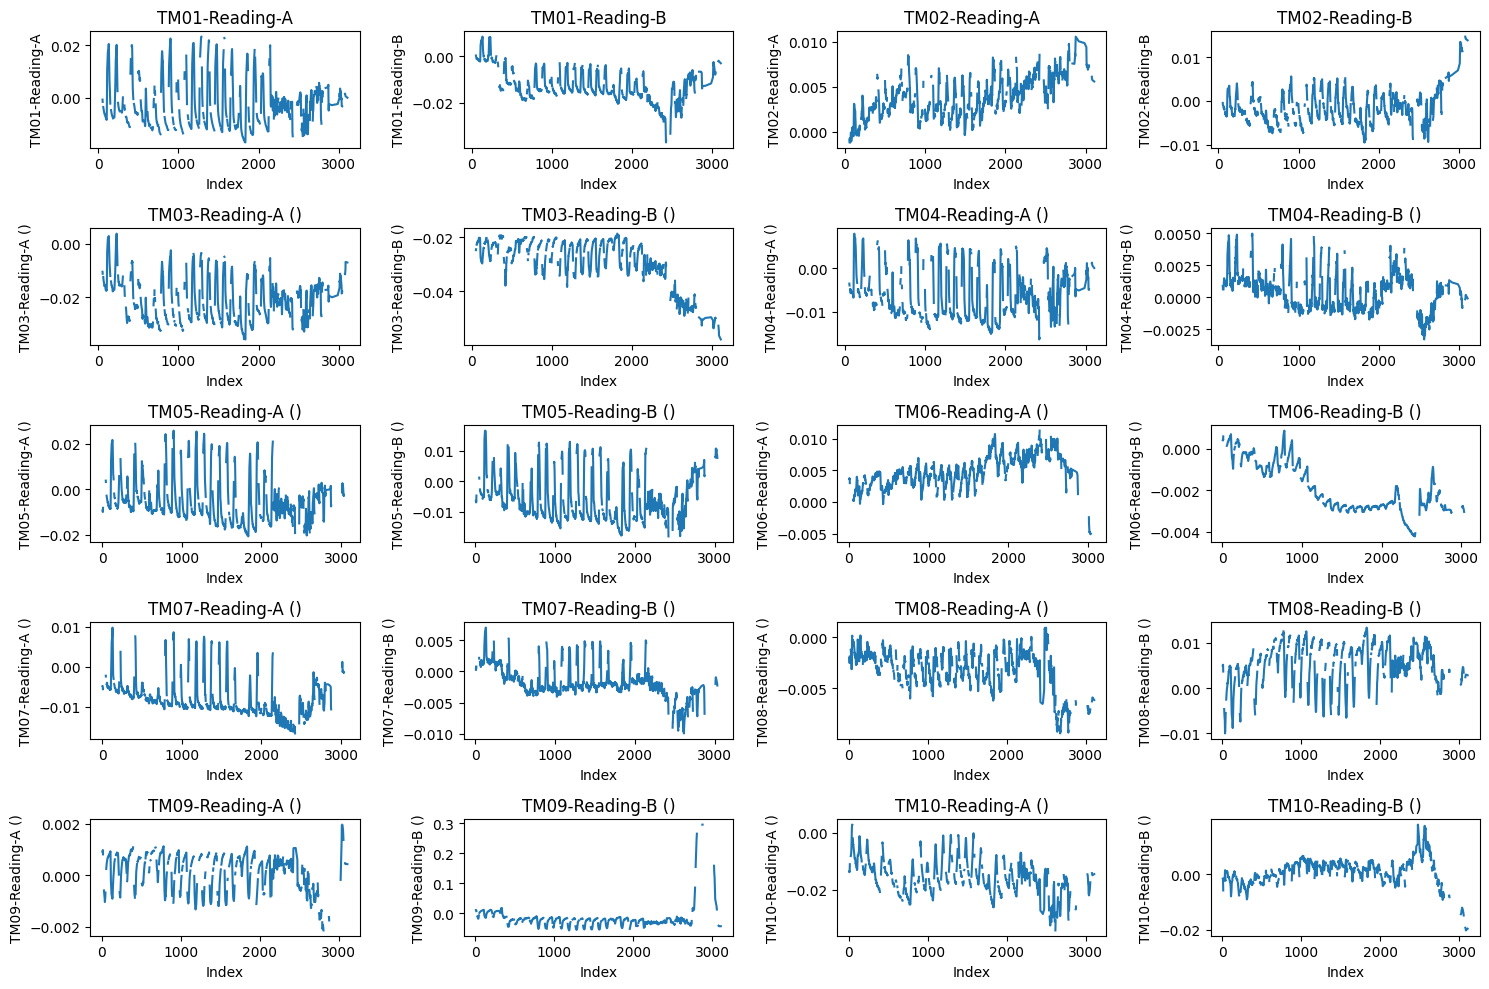

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = r"/content/modified_tilt_meter_merged_data.csv"  # Use a raw string to avoid escape characters
dataset = pd.read_csv(file_path)

# Function to select only required columns
def select_columns(data, columns):
    return data[columns]

# Function to apply moving average smoothing window
def apply_moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Function to remove outliers using the average method
def remove_outliers_avg(data, threshold=3):
    mean = data.mean()
    std = data.std()
    # Define bounds for outliers
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    # Filter out outliers
    data_clean = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]
    return data_clean

# Specify the columns to select and sort
columns_to_select = [
    'TM01-Reading-A', 'TM01-Reading-B',
    'TM02-Reading-A', 'TM02-Reading-B',
    'TM03-Reading-A ()', 'TM03-Reading-B ()',
    'TM04-Reading-A ()', 'TM04-Reading-B ()',
    'TM05-Reading-A ()', 'TM05-Reading-B ()',
    'TM06-Reading-A ()', 'TM06-Reading-B ()',
    'TM07-Reading-A ()', 'TM07-Reading-B ()',
    'TM08-Reading-A ()', 'TM08-Reading-B ()',
    'TM09-Reading-A ()', 'TM09-Reading-B ()',
    'TM10-Reading-A ()', 'TM10-Reading-B ()'
]

# Select only the required columns
dataset_selected = select_columns(dataset, columns_to_select)

# Remove outliers from the dataset
dataset_clean = remove_outliers_avg(dataset_selected)

# Apply moving average smoothing window on selected column data
window_size = 6  # Define the window size
dataset_smoothed = apply_moving_average(dataset_clean, window_size)

# Save the cleaned and smoothed data to a new CSV file
output_file_path = r"/tilt_meter_data_.csv"
dataset_smoothed.to_csv(output_file_path, index=False)

# Determine the layout of the subplots (e.g., 5 rows by 4 columns)
num_columns = 4
num_rows = (len(columns_to_select) + num_columns - 1) // num_columns  # Ceiling division

# Create subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot the cleaned and smoothed data for each column
for i, column in enumerate(dataset_smoothed.columns):
    axs[i].plot(dataset_smoothed[column])
    axs[i].set_title(column)
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(column)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

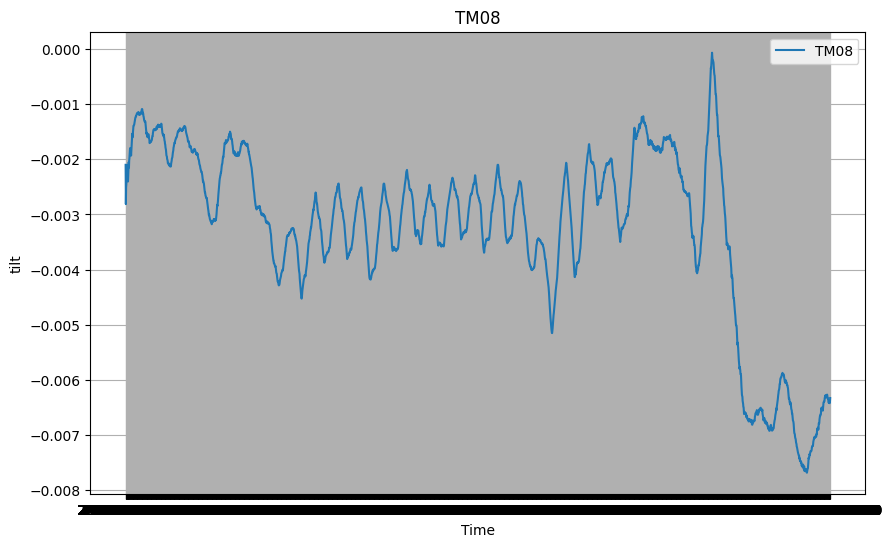

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the dataset
df = pd.read_csv(r"/content/modified_tilt_meter_merged_data.csv")

# Step 2: Inspect the dataset
result = df[["Date Time (UTC+08:00)", "TM08-Reading-A ()", "TM08-Reading-B ()",]].copy()

# Step 3: Ensure all relevant columns are numeric, forcing errors to NaN
for column in ["TM08-Reading-A ()", "TM08-Reading-B ()"]:
    result.loc[:, column] = pd.to_numeric(result[column], errors='coerce')

# Step 4: Handle NaN values (replace with column mean)
columns_to_fillna = ["TM08-Reading-A ()", "TM08-Reading-B ()"]
result.loc[:, columns_to_fillna] = result[columns_to_fillna].fillna(result[columns_to_fillna].mean())

# Step 5: Remove outliers using IQR method
def remove_outliers(result, column):
    Q1 = result[column].quantile(0.25)
    Q3 = result[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return result[(result[column] >= lower_bound) & (result[column] <= upper_bound)]

for column in ["TM08-Reading-A ()", "TM08-Reading-B ()"]:
    result = remove_outliers(result, column)

# Step 6: Apply smoothing using a rolling window only on CM01
window_size = 60 # Define the window size
result.loc[:, "TM08-Reading-A ()"] = result["TM08-Reading-A ()"].rolling(window=window_size, min_periods=1).mean()

# Step 7: Plot the cleaned and smoothed data
plt.figure(figsize=(10, 6))

# Plot each crack metric over time
plt.plot(result['Date Time (UTC+08:00)'], result["TM08-Reading-A ()"], label='TM08')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('tilt')
plt.title('TM08')

# Adding a legend
plt.legend()

# Adding a grid for better readability
plt.grid(True)

# Display the plot
plt.show()

inverse velocity and percentiles

In [ ]:
pip install watchdog


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 1.8 MB/s eta 0:00:00


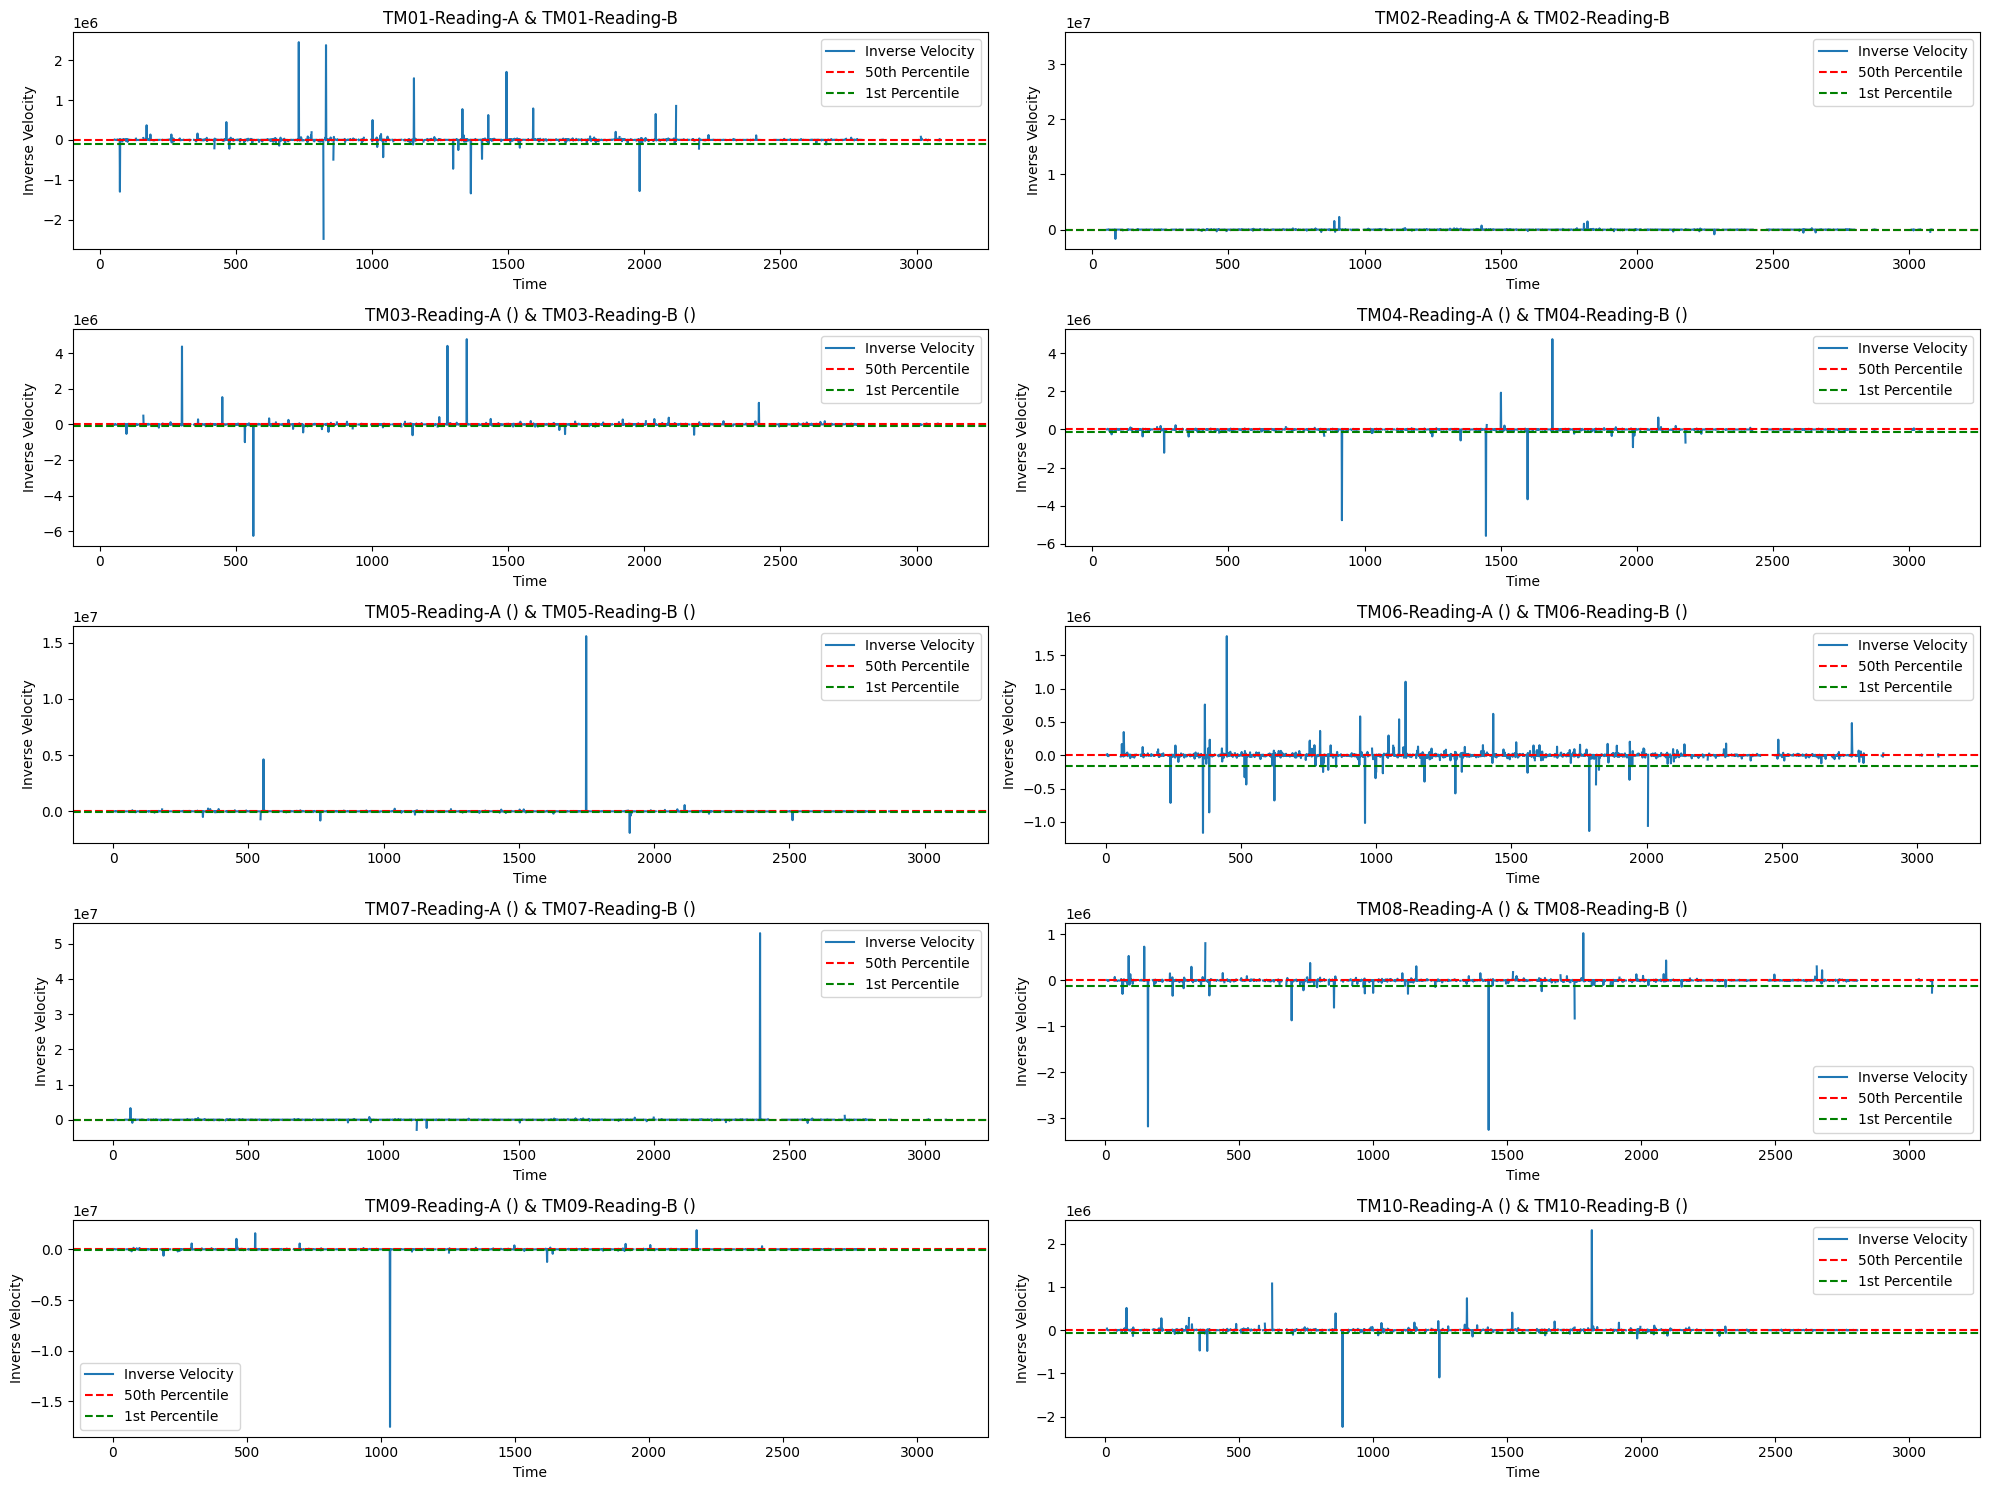

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

file_path = r"/content/modified_tilt_meter_merged_data.csv"
output_file_path = r"/tilt_meter.csv"

# Global variables to store data
dataset = None
result_data = pd.DataFrame()

# Function to select only required columns
def select_columns(data, columns):
    return data[columns]

# Function to apply moving average smoothing window
def apply_moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Function to remove outliers using the average method
def remove_outliers_avg(data, threshold=3):
    mean = data.mean()
    std = data.std()
    # Define bounds for outliers
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    # Filter out outliers
    data_clean = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]
    return data_clean

# Function to calculate resultant displacement
def calculate_resultant_displacement(data_a, data_b):
    return np.sqrt(data_a**2 + data_b**2)

# Function to calculate velocity (difference between consecutive measurements)
def calculate_velocity(data):
    return data.diff()

# Function to calculate inverse velocity
def calculate_inverse_velocity(velocity):
    return 1 / velocity

# Function to process the data
def process_data(dataset):
    global result_data

    # Extract the date column
    date_column = 'Date Time (UTC+08:00)'
    dates = dataset[date_column]

    # Specify the columns to select
    columns_to_select = [
        'TM01-Reading-A', 'TM01-Reading-B',
        'TM02-Reading-A', 'TM02-Reading-B',
        'TM03-Reading-A ()', 'TM03-Reading-B ()',
        'TM04-Reading-A ()', 'TM04-Reading-B ()',
        'TM05-Reading-A ()', 'TM05-Reading-B ()',
        'TM06-Reading-A ()', 'TM06-Reading-B ()',
        'TM07-Reading-A ()', 'TM07-Reading-B ()',
        'TM08-Reading-A ()', 'TM08-Reading-B ()',
        'TM09-Reading-A ()', 'TM09-Reading-B ()',
        'TM10-Reading-A ()', 'TM10-Reading-B ()'
    ]

    # Select only the required columns
    dataset_selected = select_columns(dataset, columns_to_select)

    # Remove outliers from the dataset
    dataset_clean = remove_outliers_avg(dataset_selected)

    # Apply moving average smoothing window on selected column data
    window_size = 4  # Define the window size
    dataset_smoothed = apply_moving_average(dataset_clean, window_size)

    # Prepare a new DataFrame to store displacement, velocity, and inverse velocity
    result_data = pd.DataFrame()
    result_data['Date'] = dates

    # Calculate and store displacement, velocity, and inverse velocity for each tilt meter
    for i in range(0, len(columns_to_select), 2):
        column_a = columns_to_select[i]
        column_b = columns_to_select[i + 1]

        # Calculate resultant displacement
        resultant_displacement = calculate_resultant_displacement(dataset_smoothed[column_a], dataset_smoothed[column_b])

        # Calculate velocity
        velocity = calculate_velocity(resultant_displacement)

        # Calculate inverse velocity
        inverse_velocity = calculate_inverse_velocity(velocity)

        # Calculate quantiles for inverse_velocity
        inverse_velocity_q50 = inverse_velocity.quantile(0.5)
        inverse_velocity_q01 = inverse_velocity.quantile(0.01)

        # Append the calculated data to the result DataFrame
        tilt_meter_id = column_a.split('-')[0]
        result_data[f'{tilt_meter_id}_displacement'] = resultant_displacement
        result_data[f'{tilt_meter_id}_velocity'] = velocity
        result_data[f'{tilt_meter_id}_inverse_velocity'] = inverse_velocity
        result_data[f'{tilt_meter_id}_inv_vel_50th_percentile'] = inverse_velocity_q50
        result_data[f'{tilt_meter_id}_inv_vel_1st_percentile'] = inverse_velocity_q01

    # Save the result data to a new CSV file
    result_data.to_csv(output_file_path, index=False)
    plot_data()

# Function to plot the data
def plot_data():
    global result_data
    columns_to_select = [
        'TM01-Reading-A', 'TM01-Reading-B',
        'TM02-Reading-A', 'TM02-Reading-B',
        'TM03-Reading-A ()', 'TM03-Reading-B ()',
        'TM04-Reading-A ()', 'TM04-Reading-B ()',
        'TM05-Reading-A ()', 'TM05-Reading-B ()',
        'TM06-Reading-A ()', 'TM06-Reading-B ()',
        'TM07-Reading-A ()', 'TM07-Reading-B ()',
        'TM08-Reading-A ()', 'TM08-Reading-B ()',
        'TM09-Reading-A ()', 'TM09-Reading-B ()',
        'TM10-Reading-A ()', 'TM10-Reading-B ()'
    ]

    # Determine the layout of the subplots (e.g., 5 rows by 4 columns)
    num_columns = 2
    num_rows = (len(columns_to_select) // 2 + num_columns - 1) // num_columns  # Ceiling division

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 15))
    axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

    # Plot the inverse velocity data for each tilt meter
    for i in range(0, len(columns_to_select), 2):
        column_a = columns_to_select[i]
        column_b = columns_to_select[i + 1]

        # Plot inverse velocity
        tilt_meter_id = column_a.split('-')[0]
        inverse_velocity = result_data[f'{tilt_meter_id}_inverse_velocity']

        # Calculate quantiles
        q50 = inverse_velocity.quantile(0.5)
        q01 = inverse_velocity.quantile(0.01)

        axs[i//2].plot(inverse_velocity, label='Inverse Velocity')
        axs[i//2].axhline(y=q50, color='r', linestyle='--', label='50th Percentile')
        axs[i//2].axhline(y=q01, color='g', linestyle='--', label='1st Percentile')

        axs[i//2].set_title(f'{column_a} & {column_b}')
        axs[i//2].set_xlabel('Time')
        axs[i//2].set_ylabel('Inverse Velocity')
        axs[i//2].legend()

    # Remove any unused subplots
    for j in range((i//2) + 1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Define event handler for file system changes
class FileChangeHandler(FileSystemEventHandler):
    def on_modified(self, event):
        if event.src_path == file_path:
            print(f'File {file_path} has been modified. Processing new data...')
            new_data = pd.read_csv(file_path)
            process_data(new_data)

# Function to start watching the file
def start_watching():
    event_handler = FileChangeHandler()
    observer = Observer()
    observer.schedule(event_handler, path=file_path, recursive=False)
    observer.start()
    try:
        while True:
            time.sleep(4 * 3600)  # Sleep for 4 hours
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

# Initial load and process of data
dataset = pd.read_csv(file_path)
process_data(dataset)

# Start watching the file for changes
start_watching()


# OOA detection

<ipython-input-7-021dc62715cb>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(dataset[date_column], dayfirst=True, errors='coerce')


OAA not detected for TM01-Reading-A & TM01-Reading-B
OAA not detected for TM02-Reading-A & TM02-Reading-B
OAA not detected for TM03-Reading-A () & TM03-Reading-B ()
OAA not detected for TM04-Reading-A () & TM04-Reading-B ()
OAA not detected for TM05-Reading-A () & TM05-Reading-B ()
OAA not detected for TM06-Reading-A () & TM06-Reading-B ()
OAA not detected for TM07-Reading-A () & TM07-Reading-B ()
OAA not detected for TM08-Reading-A () & TM08-Reading-B ()
OAA not detected for TM09-Reading-A () & TM09-Reading-B ()
OAA not detected for TM10-Reading-A () & TM10-Reading-B ()


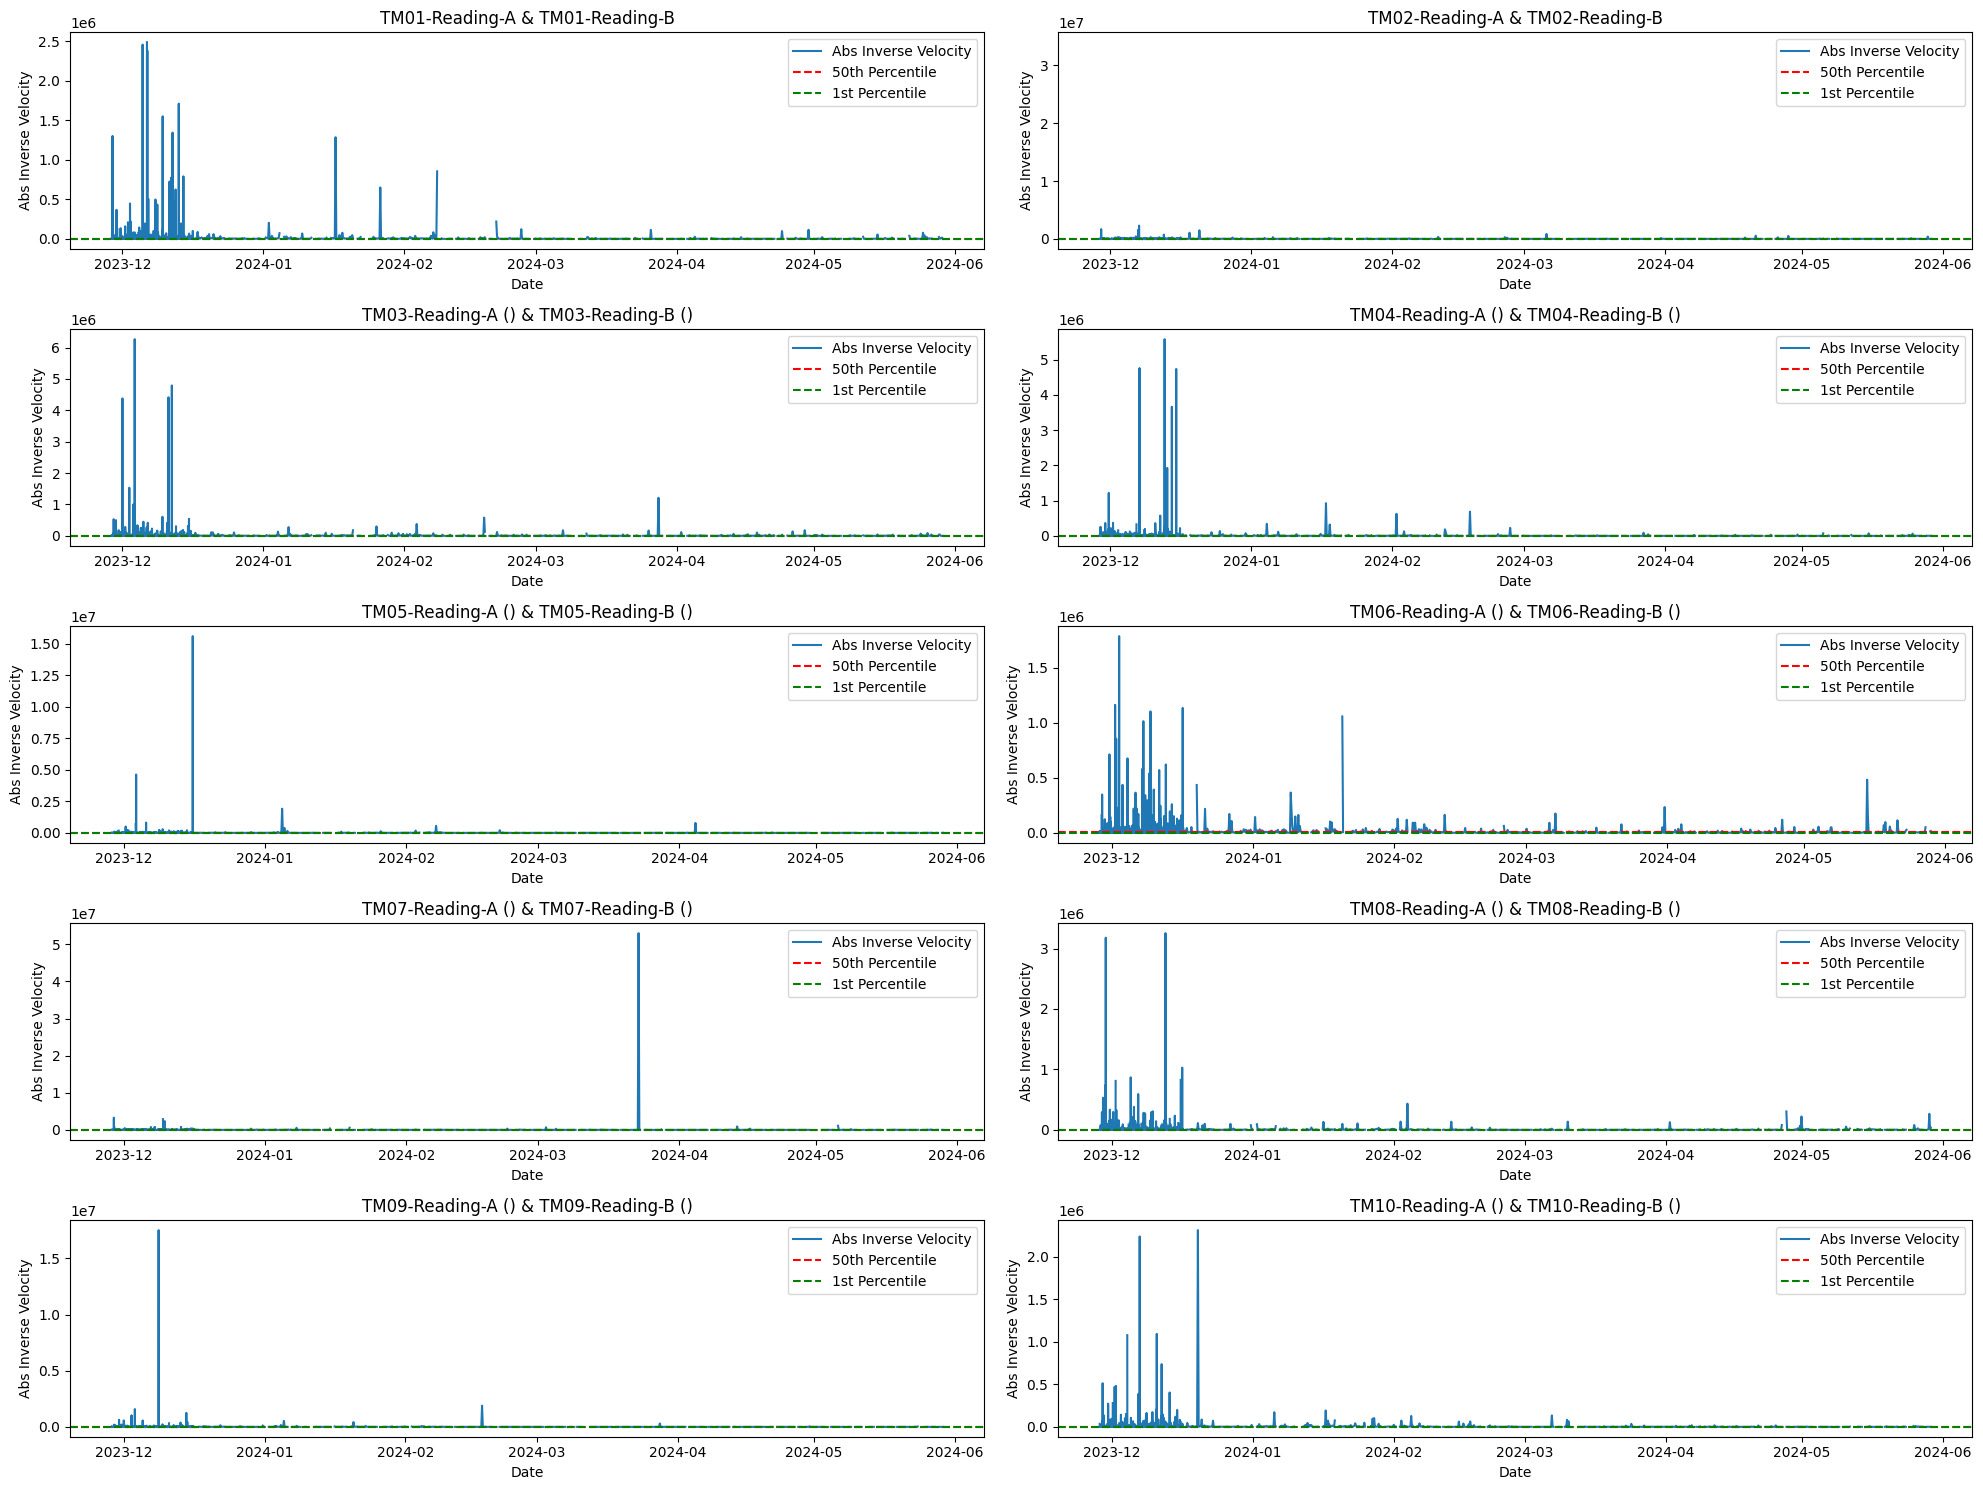

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from twilio.rest import Client

# Load the CSV file
file_path = r"/content/modified_tilt_meter_merged_data.csv"  # Use a raw string to avoid escape characters
dataset = pd.read_csv(file_path)

# Extract the date column
date_column = 'Date Time (UTC+08:00)'
dates = pd.to_datetime(dataset[date_column], dayfirst=True, errors='coerce')

# Function to select only required columns
def select_columns(data, columns):
    return data[columns]

# Function to apply moving average smoothing window
def apply_moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Function to remove outliers using the average method
def remove_outliers_avg(data, threshold=3):
    mean = data.mean()
    std = data.std()
    # Define bounds for outliers
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    # Filter out outliers
    data_clean = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]
    return data_clean

# Function to calculate resultant displacement
def calculate_resultant_displacement(data_a, data_b):
    return np.sqrt(data_a**2 + data_b**2)

# Function to calculate velocity (difference between consecutive measurements)
def calculate_velocity(data):
    return data.diff()

# Function to calculate inverse velocity
def calculate_inverse_velocity(velocity):
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_velocity = np.where(velocity != 0, 1 / velocity, np.nan)
    return inv_velocity

# Function to predict OAA using linear regression on the linear section
def predict_oaa(date_series, inv_velocity_series):
    date_numeric = (date_series - date_series.min()).dt.total_seconds().astype(int)
    date_reshape = date_numeric.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(date_reshape, inv_velocity_series)
    intercept = model.intercept_
    slope = model.coef_[0]
    failure_time_numeric = -intercept / slope
    failure_date = date_series.min() + pd.to_timedelta(failure_time_numeric, unit='s')
    return failure_date

# Function to send SMS alert
def send_alert(change_details, alert_phone_number):
    """
    Sends an SMS alert about a specific change.
    Args:
        change_details (str): A description of the change (e.g., "Sensor value exceeded threshold").
        alert_phone_number (str): The phone number to send the alert to.
    """
    client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)
    message = client.messages.create(
        body=f"Alert: {change_details}",
        from_=TWILIO_PHONE_NUMBER,
        to=alert_phone_number
    )
    print(f"SMS alert sent: {message.sid}")

# Twilio configuration (replace these with your actual credentials)
TWILIO_ACCOUNT_SID = 'AC0fa6c4d7d65456229905357c1b6bde91'
TWILIO_AUTH_TOKEN = 'f4c371d20713cdcb32f58d425616e003'
TWILIO_PHONE_NUMBER = '+12183575861'
ALERT_PHONE_NUMBER = '+917055845521'

# Specify the columns to select
columns_to_select = [
    'TM01-Reading-A', 'TM01-Reading-B',
    'TM02-Reading-A', 'TM02-Reading-B',
    'TM03-Reading-A ()', 'TM03-Reading-B ()',
    'TM04-Reading-A ()', 'TM04-Reading-B ()',
    'TM05-Reading-A ()', 'TM05-Reading-B ()',
    'TM06-Reading-A ()', 'TM06-Reading-B ()',
    'TM07-Reading-A ()', 'TM07-Reading-B ()',
    'TM08-Reading-A ()', 'TM08-Reading-B ()',
    'TM09-Reading-A ()', 'TM09-Reading-B ()',
    'TM10-Reading-A ()', 'TM10-Reading-B ()'
]

# Select only the required columns
dataset_selected = select_columns(dataset, columns_to_select)

# Remove outliers from the dataset
dataset_clean = remove_outliers_avg(dataset_selected)

# Apply moving average smoothing window on selected column data
window_size = 4  # Define the window size
dataset_smoothed = apply_moving_average(dataset_clean, window_size)

# Synchronize the lengths of dates and dataset_smoothed
dates = dates[-len(dataset_smoothed):]

# Prepare a new DataFrame to store displacement, velocity, and inverse velocity
result_data = pd.DataFrame()
result_data['Date'] = dates

# Calculate and store displacement, velocity, and inverse velocity for each tilt meter
for i in range(0, len(columns_to_select), 2):
    column_a = columns_to_select[i]
    column_b = columns_to_select[i + 1]

    # Calculate resultant displacement
    resultant_displacement = calculate_resultant_displacement(dataset_smoothed[column_a], dataset_smoothed[column_b])

    # Calculate velocity
    velocity = calculate_velocity(resultant_displacement)

    # Calculate inverse velocity
    inverse_velocity = calculate_inverse_velocity(velocity)

    # Calculate the absolute value of inverse velocity
    abs_inverse_velocity = np.abs(inverse_velocity)

    # Calculate quantiles for abs_inverse_velocity
    abs_inverse_velocity_q50 = np.nanquantile(abs_inverse_velocity, 0.5)
    abs_inverse_velocity_q01 = np.nanquantile(abs_inverse_velocity, 0.01)

    # Create a mask for the linear section
    linear_mask = (abs_inverse_velocity <= abs_inverse_velocity_q50) & (abs_inverse_velocity >= abs_inverse_velocity_q01)
    linear_section = abs_inverse_velocity[linear_mask]

    # Predict OAA if linear section is not empty
    if linear_section.size > 0:
        linear_dates = dates[linear_mask]
        failure_date = predict_oaa(linear_dates, linear_section)
        if failure_date < result_data['Date'].min() or failure_date > result_data['Date'].max():
            failure_date = None
        # Send alert if OAA is detected
        if failure_date:
            alert_message = f"Predicted time of failure (OAA) for {column_a} & {column_b}: {failure_date}"
            send_alert(alert_message, ALERT_PHONE_NUMBER)
    else:
        failure_date = None

    # Append the calculated data to the result DataFrame
    tilt_meter_id = column_a.split('-')[0]
    result_data[f'{tilt_meter_id}_displacement'] = resultant_displacement
    result_data[f'{tilt_meter_id}_velocity'] = velocity
    result_data[f'{tilt_meter_id}_inverse_velocity'] = inverse_velocity
    result_data[f'{tilt_meter_id}_abs_inverse_velocity'] = abs_inverse_velocity
    result_data[f'{tilt_meter_id}_abs_inv_vel_50th_percentile'] = abs_inverse_velocity_q50
    result_data[f'{tilt_meter_id}_abs_inv_vel_1st_percentile'] = abs_inverse_velocity_q01
    result_data[f'{tilt_meter_id}_failure_date'] = failure_date

# Save the result data to a new CSV file
output_file_path = r"/tilt_meter.csv"
result_data.to_csv(output_file_path, index=False)

# Determine the layout of the subplots (e.g., 5 rows by 4 columns)
num_columns = 2
num_rows = (len(columns_to_select) // 2 + num_columns - 1) // num_columns  # Ceiling division

# Create subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 15))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot the absolute inverse velocity data for each tilt meter
for i in range(0, len(columns_to_select), 2):
    column_a = columns_to_select[i]
    column_b = columns_to_select[i + 1]

    # Plot absolute inverse velocity
    tilt_meter_id = column_a.split('-')[0]
    abs_inverse_velocity = result_data[f'{tilt_meter_id}_abs_inverse_velocity']
    failure_date = result_data[f'{tilt_meter_id}_failure_date'].iloc[0]

    # Calculate quantiles
    q50 = abs_inverse_velocity.quantile(0.5)
    q01 = abs_inverse_velocity.quantile(0.01)

    axs[i//2].plot(dates, abs_inverse_velocity, label='Abs Inverse Velocity')
    axs[i//2].axhline(y=q50, color='r', linestyle='--', label='50th Percentile')
    axs[i//2].axhline(y=q01, color='g', linestyle='--', label='1st Percentile')
    if pd.notnull(failure_date):
        axs[i//2].axvline(x=failure_date, color='b', linestyle='--', label='Predicted Failure Time (OAA)')
    else:
        print(f'OAA not detected for {column_a} & {column_b}')
    axs[i//2].set_title(f'{column_a} & {column_b}')
    axs[i//2].set_xlabel('Date')
    axs[i//2].set_ylabel('Abs Inverse Velocity')
    axs[i//2].legend()

# Remove any unused subplots
for j in range((i//2) + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Using benchmark dataset(synthetic.csv)

Inverse velocity and percentiles

In [ ]:
!pip install twilio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.3 MB/s eta 0:00:00


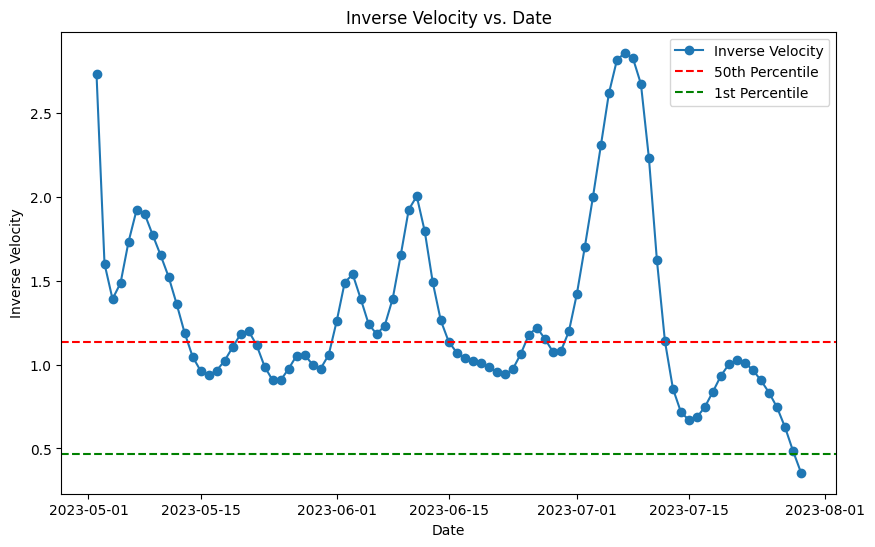

Predicted time of failure (OAA): 2023-07-29 00:00:00


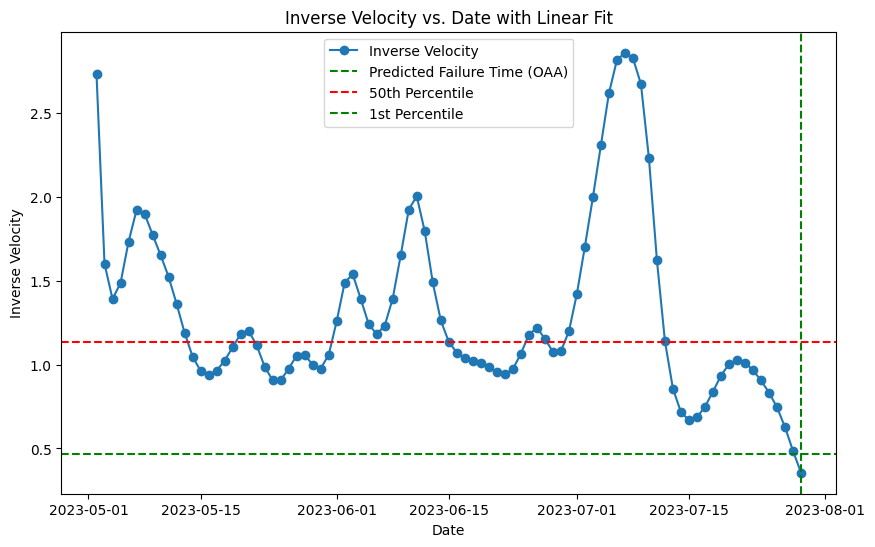

SMS alert sent: SM0cdd72ca65198f23a0b60d673b3b1649


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from twilio.rest import Client

# Load the CSV file
file_path = r"/content/synthetic.csv"  # Use a raw string to avoid escape characters
dataset = pd.read_csv(file_path, parse_dates=['date'])

# Function to select only required columns
def select_columns(data, columns):
    return data[columns]

# Function to apply kernel smoothing using Gaussian filter
def apply_kernel_smoothing(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

# Function to remove outliers using the average method
def remove_outliers_avg(data, threshold=3):
    mean = data.mean()
    std = data.std()
    # Define bounds for outliers
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    # Filter out outliers
    data_clean = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]
    return data_clean

# Function to calculate velocity (difference between consecutive measurements)
def calculate_velocity(data):
    return data.diff()

# Function to calculate inverse velocity
def calculate_inverse_velocity(velocity):
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_velocity = np.where(velocity != 0, 1 / velocity, np.nan)
    return inv_velocity

# Specify the columns to select
columns_to_select = ['date', 'disp']

# Select only the required columns
dataset_selected = select_columns(dataset, columns_to_select)

# Remove outliers from the dataset
dataset_clean = dataset_selected.copy()
dataset_clean['disp'] = remove_outliers_avg(dataset_clean[['disp']])

# Apply kernel smoothing
sigma = 2  # Define the kernel smoothing factor
dataset_clean['disp_kernel'] = apply_kernel_smoothing(dataset_clean['disp'], sigma)

# Drop rows with NaN values after smoothing
dataset_clean = dataset_clean.dropna()

# Calculate velocity for kernel smoothing method
dataset_clean['velocity_kernel'] = calculate_velocity(dataset_clean['disp_kernel'])

# Calculate inverse velocity for kernel smoothing method
dataset_clean['inverse_velocity_kernel'] = calculate_inverse_velocity(dataset_clean['velocity_kernel'])

# Calculate 50th and 1st percentiles of inverse velocity
q50 = dataset_clean['inverse_velocity_kernel'].quantile(0.5)
q01 = dataset_clean['inverse_velocity_kernel'].quantile(0.01)

# Plot inverse velocity vs. time
plt.figure(figsize=(10, 6))
plt.plot(dataset_clean['date'], dataset_clean['inverse_velocity_kernel'], 'o-', label='Inverse Velocity')
plt.axhline(y=q50, color='r', linestyle='--', label='50th Percentile')
plt.axhline(y=q01, color='g', linestyle='--', label='1st Percentile')
plt.xlabel('Date')
plt.ylabel('Inverse Velocity')
plt.title('Inverse Velocity vs. Date')
plt.legend()
plt.show()

# Identify the linear section
# Use the criteria of inverse velocity being between the 50th and 1st percentiles
linear_section = dataset_clean[(dataset_clean['inverse_velocity_kernel'] <= q50) &
                               (dataset_clean['inverse_velocity_kernel'] >= q01)]

# Ensure the linear section exists within the time range
if linear_section.empty:
    raise ValueError("No data points found in the specified percentile range for regression.")

# Linear regression
linear_time = linear_section['date'].values
linear_inv_velocity = linear_section['inverse_velocity_kernel'].values
linear_time_numeric = (linear_time - linear_time[0]).astype('timedelta64[D]').astype(int)  # Convert dates to numeric
linear_time_reshape = linear_time_numeric.reshape(-1, 1)  # Reshape for sklearn
model = LinearRegression()
model.fit(linear_time_reshape, linear_inv_velocity)

# Extrapolate to find the intersection with the time axis
intercept = model.intercept_
slope = model.coef_[0]
failure_time_numeric = -intercept / slope
failure_date = linear_time[0] + np.timedelta64(int(failure_time_numeric), 'D')

# Ensure OAA is within the time range of inverse velocity
if failure_date > dataset_clean['date'].iloc[-1]:
    failure_date = dataset_clean['date'].iloc[-1]

print(f"Predicted time of failure (OAA): {failure_date}")

# Plot the linear fit and extrapolation
plt.figure(figsize=(10, 6))
plt.plot(dataset_clean['date'], dataset_clean['inverse_velocity_kernel'], 'o-', label='Inverse Velocity')
plt.axvline(x=failure_date, color='g', linestyle='--', label='Predicted Failure Time (OAA)')
plt.axhline(y=q50, color='r', linestyle='--', label='50th Percentile')
plt.axhline(y=q01, color='g', linestyle='--', label='1st Percentile')
plt.xlabel('Date')
plt.ylabel('Inverse Velocity')
plt.title('Inverse Velocity vs. Date with Linear Fit')
plt.legend()
plt.show()

# Save the result data to a new CSV file
output_file_path = r"/tilt_meter_result_data.csv"
dataset_clean.to_csv(output_file_path, index=False)

# Alert configuration
TWILIO_ACCOUNT_SID = 'AC0fa6c4d7d65456229905357c1b6bde91'
TWILIO_AUTH_TOKEN = 'f4c371d20713cdcb32f58d425616e003'
TWILIO_PHONE_NUMBER = '+12183575861'
ALERT_PHONE_NUMBER = '+917055845521'

def send_alert(change_details, alert_phone_number=ALERT_PHONE_NUMBER):
    """
    Sends an SMS alert about a specific change.

    Args:
        change_details (str): A description of the change (e.g., "Sensor value exceeded threshold").
        alert_phone_number (str): The phone number to send the alert to.
    """
    client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)
    message = client.messages.create(
        body=f"Alert: {change_details}",
        from_=TWILIO_PHONE_NUMBER,
        to=alert_phone_number
    )
    print(f"SMS alert sent: {message.sid}")

# Send an alert if OAA is detected
alert_message = f"Predicted time of failure (OAA): {failure_date}"
send_alert(alert_message)

<ipython-input-46-ceece23ac2b6>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['velocity_kernel'] = calculate_velocity(dataset_clean['disp_kernel'])
<ipython-input-46-ceece23ac2b6>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['inverse_velocity_kernel'] = calculate_inverse_velocity(dataset_clean['velocity_kernel'])


Predicted time of failure (OAA): 2023-07-29 00:00:00


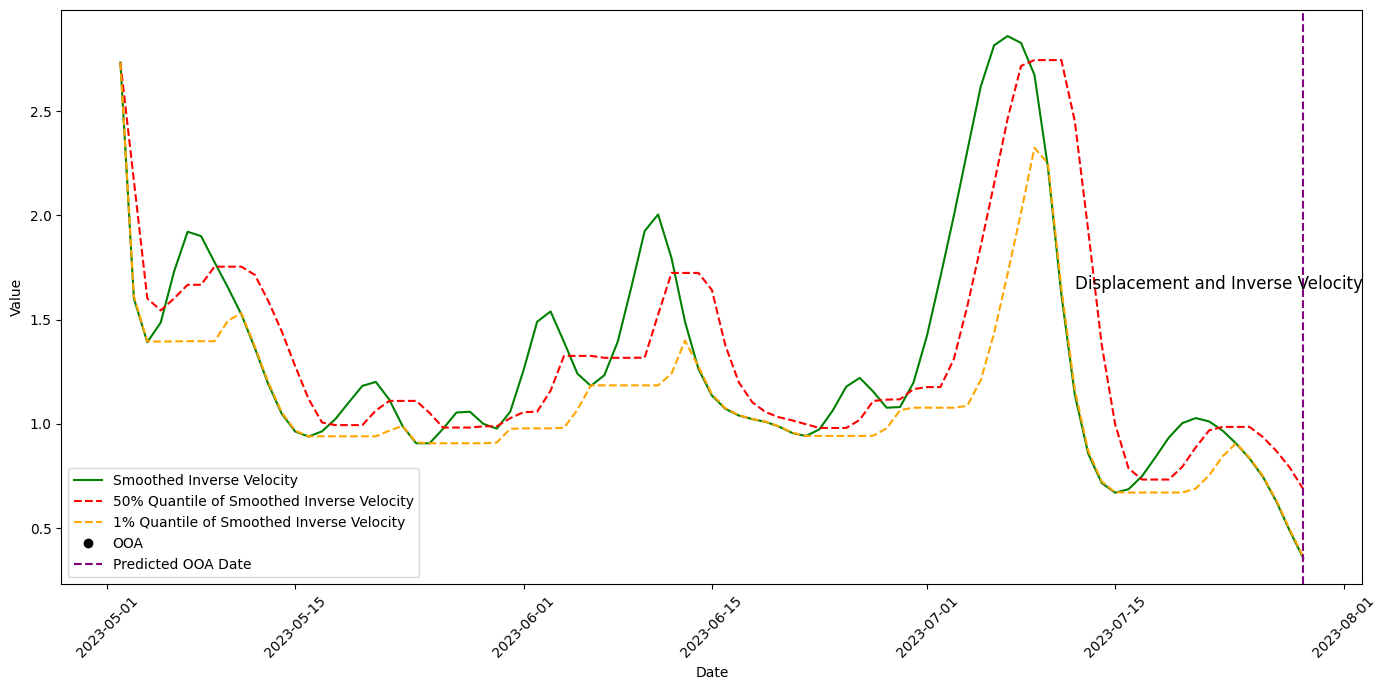

SMS alert sent: SM7c84c756ee654496085ceb7c5dd8f531


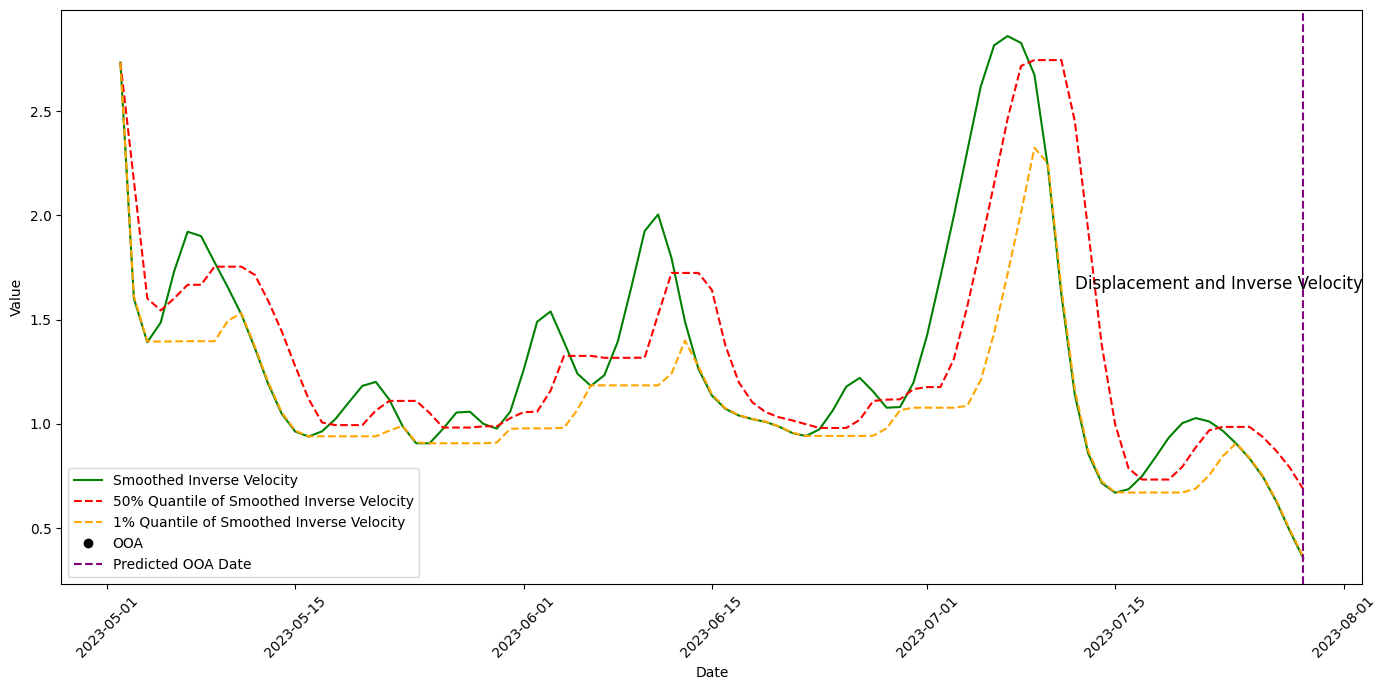

SMS alert sent: SM6beedb706a15c409660b1ea911491399


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from twilio.rest import Client
import time

# Configuration
file_path = r"/content/synthetic.csv"
output_file_path = r"/tilt_meter_result_data.csv"
data_after_ooa_file_path = r"/content/data_after_ooa.csv"
TWILIO_ACCOUNT_SID = 'AC0fa6c4d7d65456229905357c1b6bde91'
TWILIO_AUTH_TOKEN = 'f4c371d20713cdcb32f58d425616e003'
TWILIO_PHONE_NUMBER = '+12183575861'
ALERT_PHONE_NUMBER = '+917055845521'

# Functions
def select_columns(data, columns):
    return data[columns]

def remove_outliers_avg(data, threshold=3):
    mean = data.mean()
    std = data.std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    data_clean = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]
    return data_clean

def calculate_velocity(data):
    return data.diff()

def calculate_inverse_velocity(velocity):
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_velocity = np.where(velocity != 0, 1 / velocity, np.nan)
    return inv_velocity

def calculate_quantiles(series, window_size=5):
    quantile_50 = series.rolling(window=window_size, min_periods=1).quantile(0.5)
    quantile_1 = series.rolling(window=window_size, min_periods=1).quantile(0.01)
    return quantile_50, quantile_1

def apply_kernel_smoothing(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

def plot_displacement_and_quantiles(filtered_dataset, smoothed_displacement, smoothed_inverse_velocity, quantile_50, quantile_1, ooa, ooa_date, group_name):
    plt.figure(figsize=(14, 7))

    # Ensure that all series have the same length
    min_length = min(len(filtered_dataset['date']), len(smoothed_displacement), len(smoothed_inverse_velocity), len(quantile_50), len(quantile_1))

    # plt.plot(filtered_dataset['date'][:min_length], smoothed_displacement[:min_length], label='Smoothed Displacement', color='b')
    plt.plot(filtered_dataset['date'][:min_length], smoothed_inverse_velocity[:min_length], label='Smoothed Inverse Velocity', color='g')
    plt.plot(filtered_dataset['date'][:min_length], quantile_50[:min_length], label='50% Quantile of Smoothed Inverse Velocity', linestyle='--', color='r')
    plt.plot(filtered_dataset['date'][:min_length], quantile_1[:min_length], label='1% Quantile of Smoothed Inverse Velocity', linestyle='--', color='orange')

    if not ooa.empty:
        plt.plot(ooa.index, smoothed_inverse_velocity[ooa].reindex(ooa.index), 'ko', label='OOA')

    plt.axvline(x=ooa_date, color='purple', linestyle='--', label='Predicted OOA Date')

    plt.legend()
    plt.title(group_name, y=0.5, loc='right')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def find_ooa(displacement, inverse_velocity, window_size=5):
    A, B, C = displacement.shift(2 * window_size), displacement.shift(window_size), displacement
    D, E = displacement.rolling(window=window_size, min_periods=1).quantile(0.5).shift(window_size), displacement.rolling(window=window_size, min_periods=1).quantile(0.5)
    F, H = inverse_velocity.shift(window_size), inverse_velocity
    G = inverse_velocity.rolling(window=window_size, min_periods=1).quantile(0.01)
    criteria_1 = (C > B) & (B > A)
    criteria_2 = H < F
    criteria_3 = E < D
    criteria_4 = H < G
    return criteria_1 & criteria_2 & criteria_3 & criteria_4

def send_alert(change_details, alert_phone_number=ALERT_PHONE_NUMBER):
    client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)
    message = client.messages.create(
        body=f"Alert: {change_details}",
        from_=TWILIO_PHONE_NUMBER,
        to=alert_phone_number
    )
    print(f"SMS alert sent: {message.sid}")

def update_data(last_timestamp):
    dataset_new = pd.read_csv(file_path, parse_dates=['date'])
    new_data = dataset_new[dataset_new['date'] > last_timestamp]

    if new_data.empty:
        return last_timestamp

    dataset_selected_new = select_columns(new_data, columns_to_select)
    dataset_clean_new = remove_outliers_avg(dataset_selected_new)
    dataset_clean_new['disp_kernel'] = apply_kernel_smoothing(dataset_clean_new['disp'], sigma)
    dataset_clean_new = dataset_clean_new.dropna()
    dataset_clean_new['velocity_kernel'] = calculate_velocity(dataset_clean_new['disp_kernel'])
    dataset_clean_new['inverse_velocity_kernel'] = calculate_inverse_velocity(dataset_clean_new['velocity_kernel'])

    global dataset_clean
    dataset_clean = pd.concat([dataset_clean, dataset_clean_new])

    return dataset_clean['date'].max()

# Initialization
columns_to_select = ['date', 'disp']
dataset_selected = pd.read_csv(file_path, parse_dates=['date'])
dataset_selected = select_columns(dataset_selected, columns_to_select)
dataset_clean = dataset_selected.copy()
dataset_clean['disp'] = remove_outliers_avg(dataset_clean[['disp']])
sigma = 2
dataset_clean['disp_kernel'] = apply_kernel_smoothing(dataset_clean['disp'], sigma)
dataset_clean = dataset_clean.dropna()
dataset_clean['velocity_kernel'] = calculate_velocity(dataset_clean['disp_kernel'])
dataset_clean['inverse_velocity_kernel'] = calculate_inverse_velocity(dataset_clean['velocity_kernel'])
window_size = 6
quantile_50, quantile_1 = calculate_quantiles(pd.Series(dataset_clean['inverse_velocity_kernel']), window_size)
linear_section = dataset_clean[(dataset_clean['inverse_velocity_kernel'] <= quantile_50) & (dataset_clean['inverse_velocity_kernel'] >= quantile_1)]
if linear_section.empty:
    raise ValueError("No data points found in the specified percentile range for regression.")
linear_time = linear_section['date'].values
linear_inv_velocity = linear_section['inverse_velocity_kernel'].values
linear_time_numeric = (linear_time - linear_time[0]).astype('timedelta64[D]').astype(int)
linear_time_reshape = linear_time_numeric.reshape(-1, 1)
model = LinearRegression()
model.fit(linear_time_reshape, linear_inv_velocity)
intercept = model.intercept_
slope = model.coef_[0]
failure_time_numeric = -intercept / slope
failure_date = linear_time[0] + np.timedelta64(int(failure_time_numeric), 'D')
if failure_date > dataset_clean['date'].iloc[-1]:
    failure_date = dataset_clean['date'].iloc[-1]
print(f"Predicted time of failure (OAA): {failure_date}")
ooa = find_ooa(dataset_clean['disp_kernel'], dataset_clean['inverse_velocity_kernel'], window_size)
plot_displacement_and_quantiles(dataset_clean, dataset_clean['disp_kernel'], dataset_clean['inverse_velocity_kernel'], quantile_50, quantile_1, ooa, failure_date, 'Displacement and Inverse Velocity')
dataset_clean.to_csv(output_file_path, index=False)
data_after_ooa = dataset_selected[dataset_selected['date'] > failure_date]
data_after_ooa.to_csv(data_after_ooa_file_path, index=False)
alert_message = f"Predicted time of failure (OAA): {failure_date}"
send_alert(alert_message)

# Update loop
def run_updates():
    last_timestamp = dataset_clean['date'].max()
    while True:
        last_timestamp = update_data(last_timestamp)
        ooa = find_ooa(dataset_clean['disp_kernel'], dataset_clean['inverse_velocity_kernel'], window_size)
        plot_displacement_and_quantiles(dataset_clean, dataset_clean['disp_kernel'], dataset_clean['inverse_velocity_kernel'], quantile_50, quantile_1, ooa, failure_date, 'Displacement and Inverse Velocity')
        dataset_clean.to_csv(output_file_path, index=False)
        data_after_ooa = dataset_selected[dataset_selected['date'] > failure_date]
        data_after_ooa.to_csv(data_after_ooa_file_path, index=False)
        alert_message = f"Predicted time of failure (OAA): {failure_date}"
        send_alert(alert_message)
        time.sleep(4 * 3600)  # Sleep for 4 hours

# Start the update loop
run_updates()


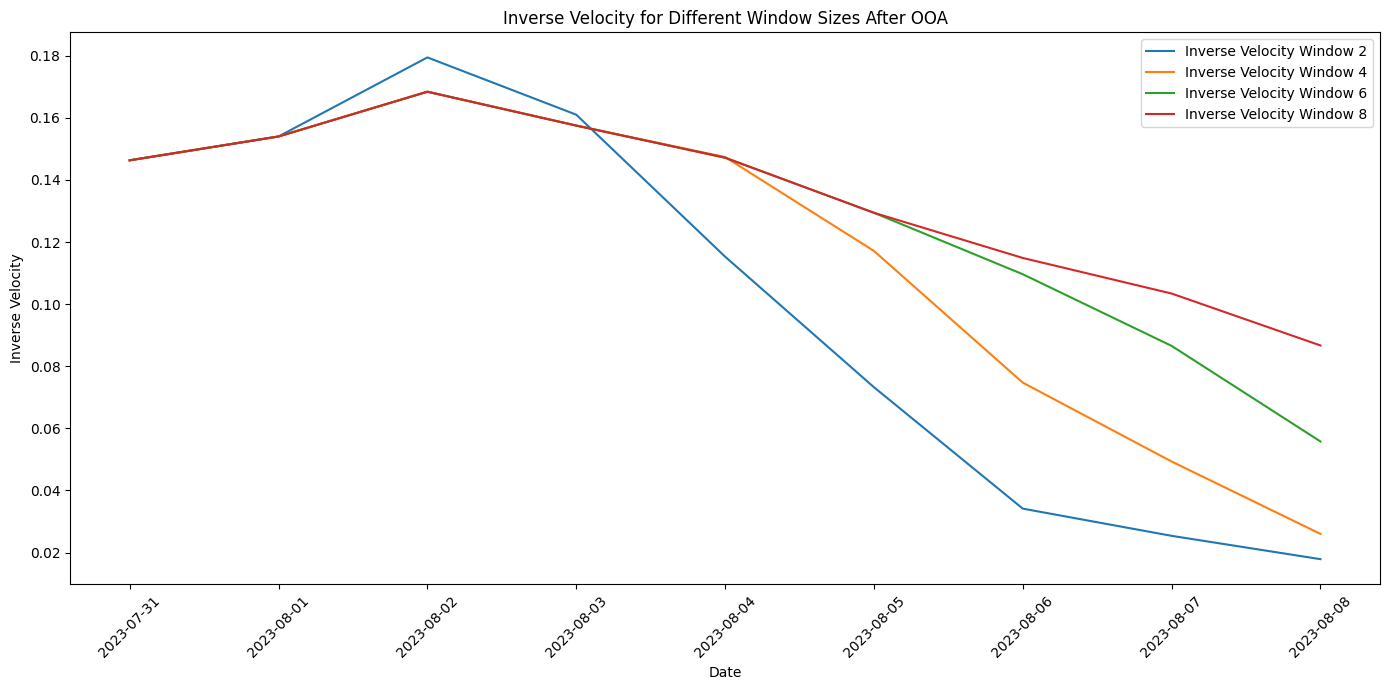

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# File path for the data after OAA
data_after_ooa_file_path = r"/content/data_after_ooa.csv"

def calculate_velocity(data):
    return data.diff()

def calculate_inverse_velocity(velocity):
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_velocity = np.where(velocity != 0, 1 / velocity, np.nan)
    return pd.Series(inv_velocity, index=velocity.index)  # Convert to pandas Series

def plot_velocity_windows(data, window_sizes):
    plt.figure(figsize=(14, 7))

    # Calculate velocity
    velocity = calculate_velocity(data['disp'])

    for window_size in window_sizes:
        # Calculate inverse velocity and convert to pandas Series
        inverse_velocity = calculate_inverse_velocity(velocity)

        # Calculate rolling mean of the inverse velocity for the given window size
        rolling_inverse_velocity = inverse_velocity.rolling(window=window_size, min_periods=1).mean()

        # Ensure that data lengths match for plotting
        min_length = min(len(data['date']), len(rolling_inverse_velocity))
        plt.plot(data['date'][:min_length], rolling_inverse_velocity[:min_length], label=f'Inverse Velocity Window {window_size}')

    plt.xlabel('Date')
    plt.ylabel('Inverse Velocity')
    plt.title('Inverse Velocity for Different Window Sizes After OOA')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def update_data(last_timestamp):
    # Load new data
    data_after_ooa_new = pd.read_csv(data_after_ooa_file_path, parse_dates=['date'])
    new_data = data_after_ooa_new[data_after_ooa_new['date'] > last_timestamp]

    if new_data.empty:
        return last_timestamp

    # Update the global dataset
    global data_after_ooa
    data_after_ooa = pd.concat([data_after_ooa, new_data])

    return data_after_ooa['date'].max()

# Initialize
data_after_ooa = pd.read_csv(data_after_ooa_file_path, parse_dates=['date'])
last_timestamp = data_after_ooa['date'].max()

# Define window sizes for plotting
window_sizes = [2, 4, 6, 8]

def run_updates():
    global last_timestamp
    while True:
        # Update data and plot
        last_timestamp = update_data(last_timestamp)
        plot_velocity_windows(data_after_ooa, window_sizes)
        time.sleep(4 * 3600)  # Sleep for 4 hours

# Start the update loop
run_updates()


Predicted time of failure (OAA): 2023-07-29 00:00:00


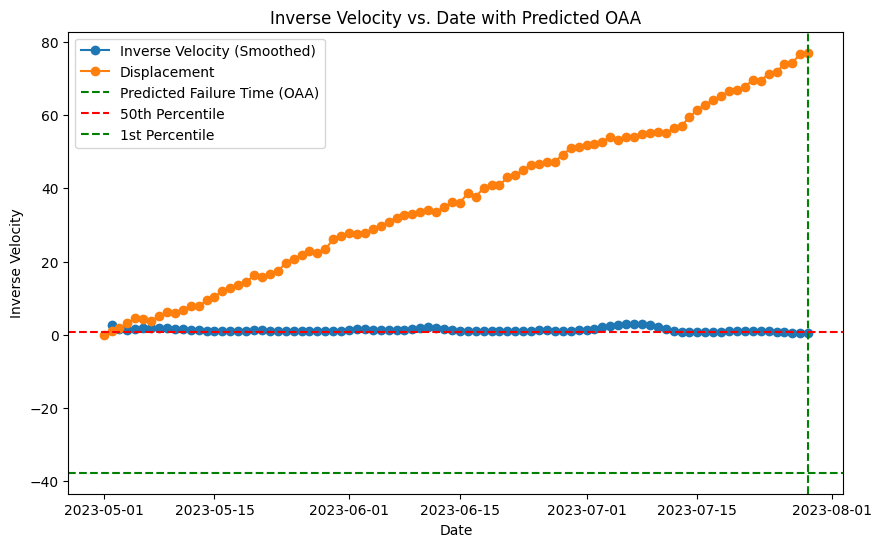

SMS alert sent: SM8c851e746eaaf98b4a0cc49b8e429424


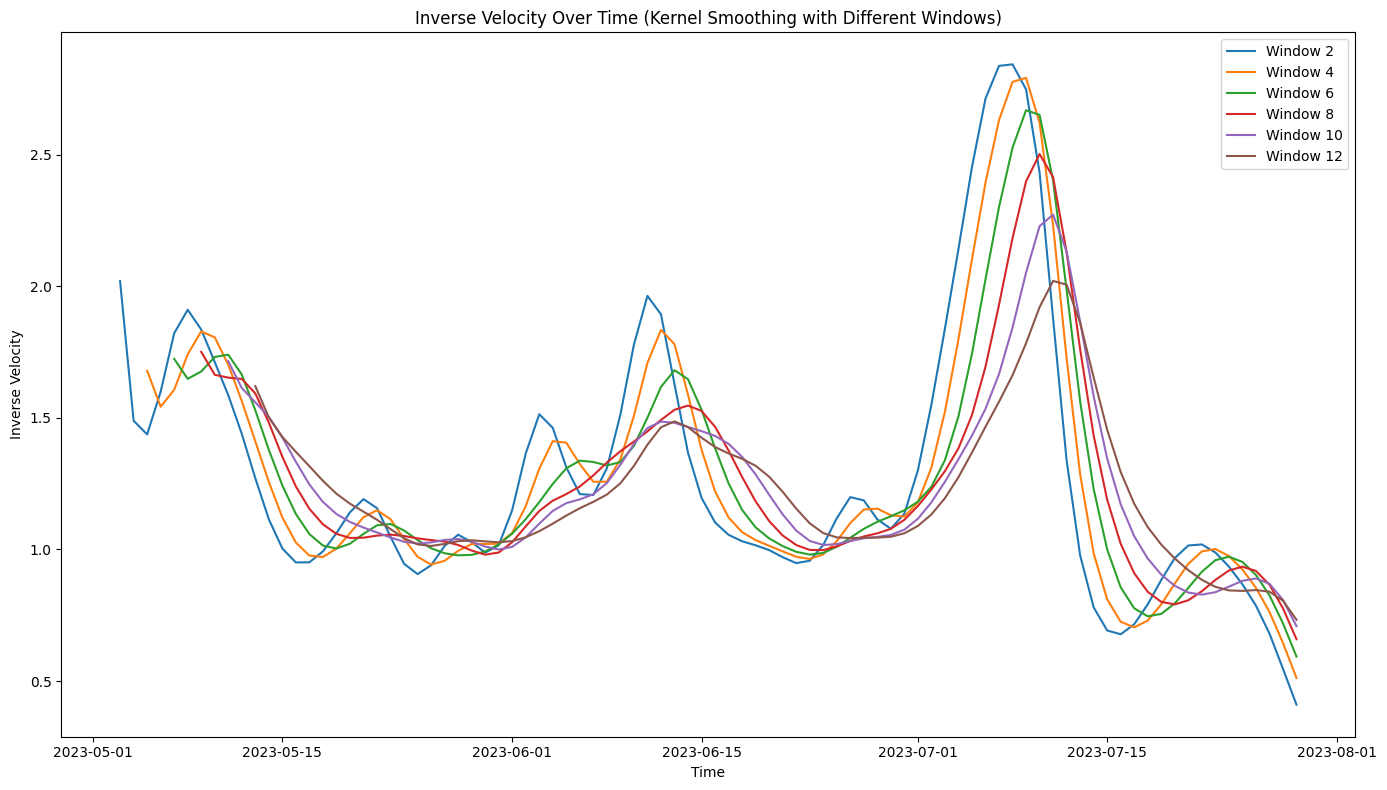

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from twilio.rest import Client
import math

# Load the CSV file
file_path = "/content/synthetic.csv"  # Update the path as needed
dataset = pd.read_csv(file_path, parse_dates=['date'])

# Function to select only required columns
def select_columns(data, columns):
    return data[columns]

# Function to apply kernel smoothing using Gaussian filter
def apply_kernel_smoothing(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

# Function to remove outliers using the average method
def remove_outliers_avg(data, threshold=3):
    mean = data.mean()
    std = data.std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    data_clean = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]
    return data_clean

# Function to calculate velocity (difference between consecutive measurements)
def calculate_velocity(data):
    return data.diff()

# Function to calculate inverse velocity
def calculate_inverse_velocity(velocity):
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_velocity = np.where(velocity != 0, 1 / velocity, np.nan)
    return inv_velocity

# Specify the columns to select
columns_to_select = ['date', 'disp']

# Select only the required columns
dataset_selected = select_columns(dataset, columns_to_select)

# Remove outliers from the dataset
dataset_clean = dataset_selected.copy()
dataset_clean['disp'] = remove_outliers_avg(dataset_clean[['disp']])

# Apply kernel smoothing
sigma = 2  # Define the kernel smoothing factor
dataset_clean['disp_kernel'] = apply_kernel_smoothing(dataset_clean['disp'], sigma)

# Drop rows with NaN values after smoothing
dataset_clean = dataset_clean.dropna()

# Calculate velocity for kernel smoothing method
dataset_clean['velocity_kernel'] = calculate_velocity(dataset_clean['disp_kernel'])

# Calculate inverse velocity for kernel smoothing method
dataset_clean['inverse_velocity_kernel'] = calculate_inverse_velocity(dataset_clean['velocity_kernel'])

# Calculate inverse velocity for original data
dataset_clean['velocity'] = calculate_velocity(dataset_clean['disp'])
dataset_clean['inverse_velocity'] = calculate_inverse_velocity(dataset_clean['velocity'])

# Calculate 50th and 1st percentiles of inverse velocity from the original data
q50 = dataset_clean['inverse_velocity'].quantile(0.5)
q01 = dataset_clean['inverse_velocity'].quantile(0.01)

# Apply kernel smoothing to the percentile data
smoothed_q50 = apply_kernel_smoothing(dataset_clean['inverse_velocity'].rolling(window=10, min_periods=1).quantile(0.5), sigma)
smoothed_q01 = apply_kernel_smoothing(dataset_clean['inverse_velocity'].rolling(window=10, min_periods=1).quantile(0.01), sigma)

# Define conditions
vw = 10  # Define the window size
dataset_clean['c1'] = (dataset_clean['disp_kernel'] - dataset_clean['disp_kernel'].shift(math.floor(0.5 * vw))) > (dataset_clean['disp_kernel'].shift(math.floor(0.5 * vw)) - dataset_clean['disp_kernel'].shift(vw))
dataset_clean['c2'] = dataset_clean['velocity_kernel'] < dataset_clean['velocity_kernel'].shift(vw)
smoothed_q50_series = pd.Series(smoothed_q50)
dataset_clean['c3'] = smoothed_q50_series.shift(vw) < smoothed_q50_series
dataset_clean['c4'] = dataset_clean['velocity_kernel'] < smoothed_q01

# Prepare the data for machine learning
X = dataset_clean[['c1', 'c2', 'c3', 'c4']].dropna()
y = np.where(dataset_clean['inverse_velocity_kernel'].iloc[X.index] < q01, 1, 0)  # Label as 1 if below 1st percentile, else 0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Identify the OAA based on the conditions and model prediction
dataset_clean['OAA_prediction'] = model.predict(dataset_clean[['c1', 'c2', 'c3', 'c4']].fillna(0))

# Find the first occurrence of OAA
failure_index = dataset_clean[dataset_clean['OAA_prediction'] == 1].index.min()
failure_date = dataset_clean.loc[failure_index, 'date'] if pd.notna(failure_index) else dataset_clean['date'].iloc[-1]

print(f"Predicted time of failure (OAA): {failure_date}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dataset_clean['date'], dataset_clean['inverse_velocity_kernel'], 'o-', label='Inverse Velocity (Smoothed)')
plt.plot(dataset_clean['date'], dataset_clean['disp'], 'o-', label='Displacement')
plt.axvline(x=failure_date, color='g', linestyle='--', label='Predicted Failure Time (OAA)')
plt.axhline(y=q50, color='r', linestyle='--', label='50th Percentile')
plt.axhline(y=q01, color='g', linestyle='--', label='1st Percentile')
plt.xlabel('Date')
plt.ylabel('Inverse Velocity')
plt.title('Inverse Velocity vs. Date with Predicted OAA')
plt.legend()
plt.show()

# Save the result data to a new CSV file
output_file_path = r"/tilt_meter_result_data.csv"
dataset_clean.to_csv(output_file_path, index=False)

# Alert configuration
TWILIO_ACCOUNT_SID = 'AC0fa6c4d7d65456229905357c1b6bde91'
TWILIO_AUTH_TOKEN = 'f4c371d20713cdcb32f58d425616e003'
TWILIO_PHONE_NUMBER = '+12183575861'
ALERT_PHONE_NUMBER = '+917055845521'

def send_alert(change_details, alert_phone_number=ALERT_PHONE_NUMBER):
    """
    Sends an SMS alert about a specific change.

    Args:
        change_details (str): A description of the change (e.g., "Sensor value exceeded threshold").
        alert_phone_number (str): The phone number to send the alert to.
    """
    client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)
    message = client.messages.create(
        body=f"Alert: {change_details}",
        from_=TWILIO_PHONE_NUMBER,
        to=alert_phone_number
    )
    print(f"SMS alert sent: {message.sid}")

# Send an alert if OAA is detected
alert_message = f"Predicted time of failure (OAA): {failure_date}"
send_alert(alert_message)

# Calculate and store velocities for different windows after OAA detection
velocity_windows = [2, 4, 6, 8, 10, 12]

# Plot inverse velocity with different windows for kernel smoothing method after OAA detection
fig, ax = plt.subplots(figsize=(14, 8))

for window in velocity_windows:
    dataset_clean[f'velocity_kernel_window_{window}'] = calculate_velocity(dataset_clean['disp_kernel']).rolling(window=window).mean()
    dataset_clean[f'inverse_velocity_kernel_window_{window}'] = calculate_inverse_velocity(dataset_clean[f'velocity_kernel_window_{window}'])
    ax.plot(dataset_clean['date'], dataset_clean[f'inverse_velocity_kernel_window_{window}'], label=f'Window {window}')

ax.set_title('Inverse Velocity Over Time (Kernel Smoothing with Different Windows)')
ax.set_xlabel('Time')
ax.set_ylabel('Inverse Velocity')
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Save the result data to a new CSV file
output_file_path = r"/kernel_smoothing_result_data.csv"
dataset_clean.to_csv(output_file_path, index=False)


In [ ]:
!pip install twilio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00


Predicted time of failure (OAA): 2024-05-29 09:30:00


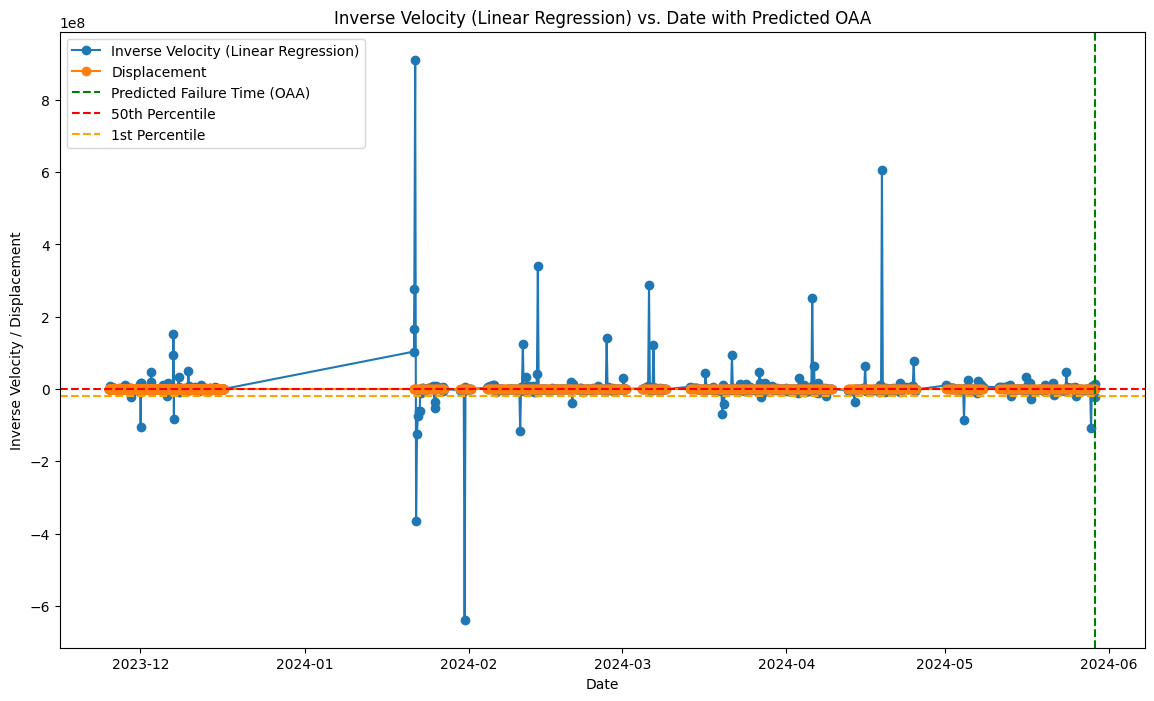

TwilioRestException: HTTP 400 error: Unable to create record: 'From' +12183575861 is not a Twilio phone number or Short Code country mismatch

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import math
import warnings
from twilio.rest import Client

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the CSV file with dayfirst=True
file_path = "/content/synthetic.csv"  # Update the path as needed
dataset = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)

# Ensure the date column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(dataset['date']):
    dataset['date'] = pd.to_datetime(dataset['date'], dayfirst=True)

# Function to select only required columns
def select_columns(data, columns):
    return data[columns]

# Function to apply kernel smoothing using Gaussian filter
def apply_kernel_smoothing(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

# Function to remove outliers using the average method
def remove_outliers_avg(data, threshold=3):
    mean = data.mean()
    std = data.std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Function to calculate velocity using linear regression over sliding windows
def calculate_velocity_linear_regression(dates, disp, window_size):
    velocities = [np.nan] * len(disp)  # Initialize with NaN

    # Convert dates to timestamps
    X = dates.map(pd.Timestamp.timestamp).values.reshape(-1, 1)  # Feature matrix

    for i in range(window_size - 1, len(disp)):
        X_window = X[i - window_size + 1:i + 1]
        y_window = disp[i - window_size + 1:i + 1]

        if np.isnan(y_window).any() or np.isnan(X_window).any():
            velocities[i] = np.nan
            continue

        model = LinearRegression()
        model.fit(X_window, y_window)
        slope = model.coef_[0]  # Velocity is the slope
        velocities[i] = slope

    return pd.Series(velocities, index=disp.index)

# Function to calculate inverse velocity
def calculate_inverse_velocity(velocity):
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_velocity = np.where(velocity != 0, 1 / velocity, np.nan)
    return inv_velocity

# Specify the columns to select
columns_to_select = ['date', 'disp']

# Select only the required columns
dataset_selected = select_columns(dataset, columns_to_select)

# Remove outliers from the dataset
dataset_clean = dataset_selected.copy()
dataset_clean['disp'] = remove_outliers_avg(dataset_clean['disp'])

# Apply kernel smoothing
sigma = 2  # Define the kernel smoothing factor
dataset_clean['disp_kernel'] = apply_kernel_smoothing(dataset_clean['disp'], sigma)

# Drop rows with NaN values after smoothing
dataset_clean = dataset_clean.dropna().reset_index(drop=True)

# Calculate velocity using linear regression
window_size = 10  # Define the window size for linear regression
dataset_clean['velocity_lr'] = calculate_velocity_linear_regression(
    dataset_clean['date'],
    dataset_clean['disp_kernel'],
    window_size
)

# Calculate inverse velocity using linear regression-based velocity
dataset_clean['inverse_velocity_lr'] = calculate_inverse_velocity(dataset_clean['velocity_lr'])

# Calculate 50th and 1st percentiles of inverse velocity
q50 = dataset_clean['inverse_velocity_lr'].quantile(0.5)
q01 = dataset_clean['inverse_velocity_lr'].quantile(0.01)

# Apply kernel smoothing to the percentile data
smoothed_q50 = pd.Series(apply_kernel_smoothing(
    dataset_clean['inverse_velocity_lr'].rolling(window=10, min_periods=1).quantile(0.5), sigma
), index=dataset_clean.index)

smoothed_q01 = pd.Series(apply_kernel_smoothing(
    dataset_clean['inverse_velocity_lr'].rolling(window=10, min_periods=1).quantile(0.01), sigma
), index=dataset_clean.index)

# Define conditions
vw = 10  # Define the window size
half_vw = math.floor(0.5 * vw)

dataset_clean['c1'] = (
    dataset_clean['disp_kernel'] - dataset_clean['disp_kernel'].shift(half_vw)
) > (
    dataset_clean['disp_kernel'].shift(half_vw) - dataset_clean['disp_kernel'].shift(vw)
)

dataset_clean['c2'] = dataset_clean['velocity_lr'] < dataset_clean['velocity_lr'].shift(vw)

dataset_clean['c3'] = smoothed_q50.shift(vw) < smoothed_q50
dataset_clean['c4'] = dataset_clean['velocity_lr'] < smoothed_q01

# Prepare the data for machine learning
X = dataset_clean[['c1', 'c2', 'c3', 'c4']].dropna()
y = np.where(dataset_clean['inverse_velocity_lr'].iloc[X.index] < q01, 1, 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Identify the OAA based on the conditions and model prediction
dataset_clean['OAA_prediction'] = model.predict(dataset_clean[['c1', 'c2', 'c3', 'c4']].fillna(0))

# Find the first occurrence of OAA
failure_index = dataset_clean[dataset_clean['OAA_prediction'] == 1].index.min()
failure_date = dataset_clean.loc[failure_index, 'date'] if pd.notna(failure_index) else dataset_clean['date'].iloc[-1]

print(f"Predicted time of failure (OAA): {failure_date}")

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(dataset_clean['date'], dataset_clean['inverse_velocity_lr'], 'o-', label='Inverse Velocity (Linear Regression)')
plt.plot(dataset_clean['date'], dataset_clean['disp'], 'o-', label='Displacement')
plt.axvline(x=failure_date, color='g', linestyle='--', label='Predicted Failure Time (OAA)')
plt.axhline(y=q50, color='r', linestyle='--', label='50th Percentile')
plt.axhline(y=q01, color='orange', linestyle='--', label='1st Percentile')
plt.xlabel('Date')
plt.ylabel('Inverse Velocity / Displacement')
plt.title('Inverse Velocity (Linear Regression) vs. Date with Predicted OAA')
plt.legend()
plt.show()

# Save the result data to a new CSV file
output_file_path = "/tilt_meter_result_data.csv"  # Use forward slashes for compatibility
dataset_clean.to_csv(output_file_path, index=False)

# Alert configuration
TWILIO_ACCOUNT_SID = 'AC0fa6c4d7d65456229905357c1b6bde91'
TWILIO_AUTH_TOKEN = 'f4c371d20713cdcb32f58d425616e003'
TWILIO_PHONE_NUMBER = '+12183575861'
ALERT_PHONE_NUMBER = '+917055845521'

def send_alert(change_details, alert_phone_number=ALERT_PHONE_NUMBER):
    client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)
    message = client.messages.create(
        body=f"Alert: {change_details}",
        from_=TWILIO_PHONE_NUMBER,
        to=alert_phone_number
    )
    print(f"SMS alert sent: {message.sid}")

# Send an alert if OAA is detected
if pd.notna(failure_date):
    alert_message = f"Predicted time of failure (OAA): {failure_date}"
    send_alert(alert_message)
else:
    print("No OAA detected; no alert sent.")

# Calculate and store velocities for different windows after OAA detection using linear regression
velocity_windows = [2, 4, 6, 8, 10, 12]

# Plot inverse velocity with different windows for linear regression-based method after OAA detection
fig, ax = plt.subplots(figsize=(14, 8))

for window in velocity_windows:
    dataset_clean[f'velocity_lr_window_{window}'] = calculate_velocity_linear_regression(
        dataset_clean['date'],
        dataset_clean['disp_kernel'],
        window
    )
    dataset_clean[f'inverse_velocity_lr_window_{window}'] = calculate_inverse_velocity(
        dataset_clean[f'velocity_lr_window_{window}']
    )
    ax.plot(
        dataset_clean['date'],
        dataset_clean[f'inverse_velocity_lr_window_{window}'],
        label=f'Window {window}'
    )

ax.set_title('Inverse Velocity Over Time (Linear Regression with Different Windows)')
ax.set_xlabel('Date')
ax.set_ylabel('Inverse Velocity')
ax.legend()
plt.tight_layout()
plt.show()

# Save the velocity windowed data to a new CSV file
output_file_path_kernel = "/linear_regression_velocity_result_data.csv"
dataset_clean.to_csv(output_file_path_kernel, index=False)
